In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C:\Users\annek\AppData\Local\Temp\ipykernel_11044\2685670889.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_11044\2685670889.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_11044\2685670889.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_11044\2685670889.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is depr

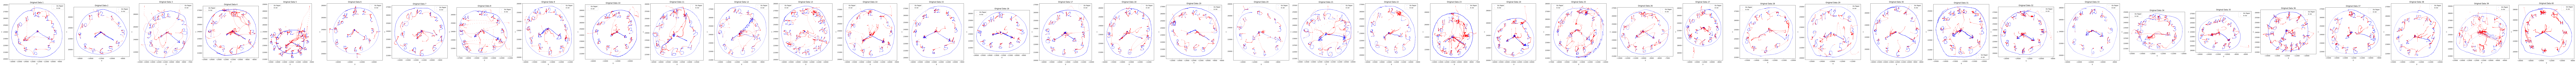

Processed data shape: (151693, 3)
Average number of data points: 3792


In [27]:
# Cell 2 (unchanged)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        df = df.iloc[:, [0, 1, 3]]  # Select x, y, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points


directory = 'Task6'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=40)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")


In [35]:
# Cell 3 (modified)
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(3,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    def call(self, x):
        return self.model(x)

class VAEGAN(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAEGAN, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(3,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(3, activation='sigmoid')
        ])
        self.discriminator = Discriminator()

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy = decoded[:, :2]
        pen_status = tf.round(decoded[:, 2])
        return tf.concat([xy, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar


In [36]:
# Cell 4 (modified)
def compute_loss(vaegan, x):
    x_reconstructed, mean, logvar = vaegan(x)
    
    # VAE Loss
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(x[:, :2], x_reconstructed[:, :2]))
    pen_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 2], x_reconstructed[:, 2]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))

    # GAN Loss
    real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(vaegan.discriminator(x)), vaegan.discriminator(x)))
    fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(vaegan.discriminator(x_reconstructed)), vaegan.discriminator(x_reconstructed)))
    adversarial_loss = real_loss + fake_loss

    vae_loss = reconstruction_loss + pen_loss + vaegan.beta * kl_loss
    total_loss = vae_loss + adversarial_loss

    return total_loss, reconstruction_loss, kl_loss, adversarial_loss

latent_dim = 256
beta = 0.0001
learning_rate = 0.001

vaegan = VAEGAN(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [38]:
# Cell 5 (modified)
@tf.function
def train_step(vaegan, x, optimizer):
    with tf.GradientTape() as tape:
        total_loss, reconstruction_loss, kl_loss, adversarial_loss = compute_loss(vaegan, x)
    gradients = tape.gradient(total_loss, vaegan.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vaegan.trainable_variables))
    return total_loss, reconstruction_loss, kl_loss, adversarial_loss

batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data).shuffle(10000).batch(batch_size)

epochs = 10
early_stopping_patience = 10
min_delta = 0.0001
best_loss = float('inf')
patience_counter = 0

total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
adversarial_loss_history = []

for epoch in range(epochs):
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    adversarial_loss_sum = 0
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            total_loss_batch, reconstruction_loss, kl_loss, adversarial_loss = train_step(vaegan, batch, optimizer)
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss
            adversarial_loss_sum += adversarial_loss
            pbar.update(1)
            pbar.set_postfix({'Total Loss': float(total_loss_batch), 'Reconstruction Loss': float(reconstruction_loss),
                              'KL Loss': float(kl_loss), 'Adversarial Loss': float(adversarial_loss)})

    total_loss /= num_batches
    reconstruction_loss_avg = reconstruction_loss_sum / num_batches
    kl_loss_avg = kl_loss_sum / num_batches
    adversarial_loss_avg = adversarial_loss_sum / num_batches

    total_loss_history.append(total_loss)
    reconstruction_loss_history.append(reconstruction_loss_avg)
    kl_loss_history.append(kl_loss_avg)
    adversarial_loss_history.append(adversarial_loss_avg)

    print(f'Epoch {epoch+1}/{epochs}: Total Loss: {total_loss:.4f}, Reconstruction Loss: {reconstruction_loss_avg:.4f}, KL Loss: {kl_loss_avg:.4f}, Adversarial Loss: {adversarial_loss_avg:.4f}')

    if total_loss < best_loss - min_delta:
        best_loss = total_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

Epoch 1/10:   0%|          | 0/593 [00:00<?, ?batch/s]

Epoch 1/10: 100%|██████████| 593/593 [00:17<00:00, 33.58batch/s, Total Loss=3.69, Reconstruction Loss=0.138, KL Loss=3.71, Adversarial Loss=0.00509]


Epoch 1/10: Total Loss: 7.7174, Reconstruction Loss: 0.1698, KL Loss: 3.0935, Adversarial Loss: 0.0272


Epoch 2/10: 100%|██████████| 593/593 [00:14<00:00, 40.28batch/s, Total Loss=6.66, Reconstruction Loss=0.142, KL Loss=3.22, Adversarial Loss=0.00352]


Epoch 2/10: Total Loss: 7.6893, Reconstruction Loss: 0.1535, KL Loss: 3.6078, Adversarial Loss: 0.0131


Epoch 3/10: 100%|██████████| 593/593 [00:10<00:00, 58.17batch/s, Total Loss=5.5, Reconstruction Loss=0.122, KL Loss=2.56, Adversarial Loss=0.00206]  


Epoch 3/10: Total Loss: 7.6815, Reconstruction Loss: 0.1494, KL Loss: 2.8971, Adversarial Loss: 0.0103


Epoch 4/10: 100%|██████████| 593/593 [00:10<00:00, 56.53batch/s, Total Loss=5.97, Reconstruction Loss=0.142, KL Loss=2.47, Adversarial Loss=0.00152]


Epoch 4/10: Total Loss: 7.6775, Reconstruction Loss: 0.1457, KL Loss: 2.6079, Adversarial Loss: 0.0097


Epoch 5/10: 100%|██████████| 593/593 [00:10<00:00, 59.08batch/s, Total Loss=6.08, Reconstruction Loss=0.133, KL Loss=2.2, Adversarial Loss=0.00184]  


Epoch 5/10: Total Loss: 7.6753, Reconstruction Loss: 0.1437, KL Loss: 2.3182, Adversarial Loss: 0.0095


Epoch 6/10: 100%|██████████| 593/593 [00:09<00:00, 60.79batch/s, Total Loss=6.32, Reconstruction Loss=0.141, KL Loss=2.08, Adversarial Loss=0.0022]  


Epoch 6/10: Total Loss: 7.6743, Reconstruction Loss: 0.1419, KL Loss: 2.1616, Adversarial Loss: 0.0101


Epoch 7/10: 100%|██████████| 593/593 [00:10<00:00, 58.01batch/s, Total Loss=5.39, Reconstruction Loss=0.0851, KL Loss=1.9, Adversarial Loss=0.0438]  


Epoch 7/10: Total Loss: 7.6362, Reconstruction Loss: 0.1030, KL Loss: 2.0010, Adversarial Loss: 0.0115


Epoch 8/10: 100%|██████████| 593/593 [00:11<00:00, 51.83batch/s, Total Loss=6.02, Reconstruction Loss=0.0734, KL Loss=2.01, Adversarial Loss=0.00458] 


Epoch 8/10: Total Loss: 7.6084, Reconstruction Loss: 0.0785, KL Loss: 2.0966, Adversarial Loss: 0.0078


Epoch 9/10: 100%|██████████| 593/593 [00:08<00:00, 71.77batch/s, Total Loss=5.45, Reconstruction Loss=0.0751, KL Loss=2.18, Adversarial Loss=0.00147] 


Epoch 9/10: Total Loss: 7.6051, Reconstruction Loss: 0.0746, KL Loss: 2.1776, Adversarial Loss: 0.0087


Epoch 10/10: 100%|██████████| 593/593 [00:08<00:00, 72.38batch/s, Total Loss=6.13, Reconstruction Loss=0.0718, KL Loss=2.21, Adversarial Loss=0.00226] 

Epoch 10/10: Total Loss: 7.6018, Reconstruction Loss: 0.0700, KL Loss: 2.1918, Adversarial Loss: 0.0096


C:\Users\annek\AppData\Local\Temp\ipykernel_11044\1143761989.py:58: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


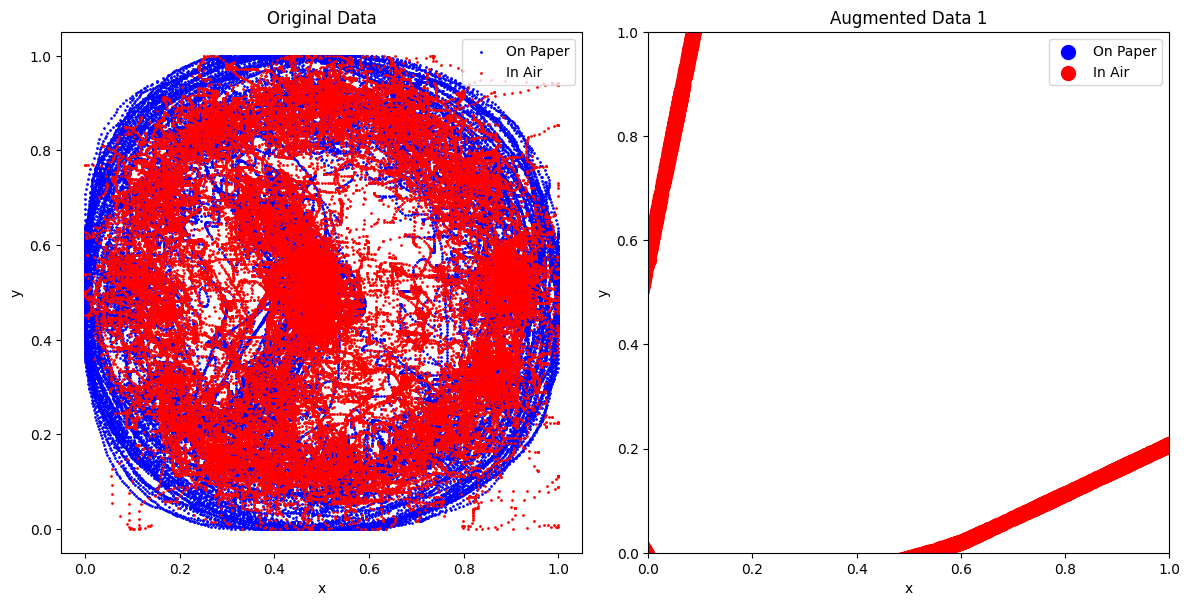

In [39]:
# Cell 6 (updated for VAEGAN)
def generate_augmented_data_vaegan(model, num_augmented_files, avg_data_points, variability=0.1):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        # Encode the original data
        mean, logvar = model.encode(tf.convert_to_tensor(combined_data, dtype=tf.float32))
        # Reparameterize to get latent space representation
        z = model.reparameterize(mean, logvar)
        # Decode to generate augmented data
        augmented_data = model.decode(z).numpy()

        # Determine the number of data points for this augmented dataset
        num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        # Truncate or pad the augmented data to match the number of data points
        if num_points < augmented_data.shape[0]:
            augmented_datasets.append(augmented_data[:num_points])
        else:
            padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
            augmented_datasets.append(np.vstack([augmented_data, padding]))

    return augmented_datasets

# Generate augmented data using VAEGAN
num_augmented_files = 1
augmented_datasets_vaegan = generate_augmented_data_vaegan(vaegan, num_augmented_files, avg_data_points)

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6 * (num_augmented_files + 1), 6))
original_on_paper = combined_data[combined_data[:, 2] == 1]
original_in_air = combined_data[combined_data[:, 2] == 0]
axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
axs[0].set_title('Original Data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
axs[0].legend()

# Set consistent axis limits for square aspect ratio
x_min, x_max = combined_data[:, 0].min(), combined_data[:, 0].max()
y_min, y_max = combined_data[:, 1].min(), combined_data[:, 1].max()

for i, augmented_data in enumerate(augmented_datasets_vaegan):
    augmented_on_paper = augmented_data[augmented_data[:, 2] == 1]
    augmented_in_air = augmented_data[augmented_data[:, 2] == 0]
    axs[i + 1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=100, label='On Paper')
    axs[i + 1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=100, label='In Air')
    axs[i + 1].set_title(f'Augmented Data {i + 1}')
    axs[i + 1].set_xlabel('x')
    axs[i + 1].set_ylabel('y')
    axs[i + 1].set_aspect('equal')
    axs[i + 1].set_xlim(x_min, x_max)
    axs[i + 1].set_ylim(y_min, y_max)
    axs[i + 1].legend()

plt.tight_layout()
plt.show()


In [40]:
# Cell 7 (Download Augmented Data)
def download_augmented_data(augmented_datasets, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, augmented_data in enumerate(augmented_datasets):
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data, columns=['x', 'y', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

download_augmented_data(augmented_datasets_vaegan)


Saved augmented_data\augmented_data_1.csv
